<a href="https://colab.research.google.com/github/pelinbalci/TF_Custom_Models/blob/main/Implement_Resnet_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement RESNET

In [ ]:
!pip install tensorflow_datasets

In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer

# Visualize model
from tensorflow.keras.layers import Layer
from tensorflow.python.keras.utils.vis_utils import pydot
from tensorflow.python.keras.utils.vis_utils import plot_model

# Error : Function call stack:train_function
# https://github.com/tensorflow/tensorflow/issues/43174
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

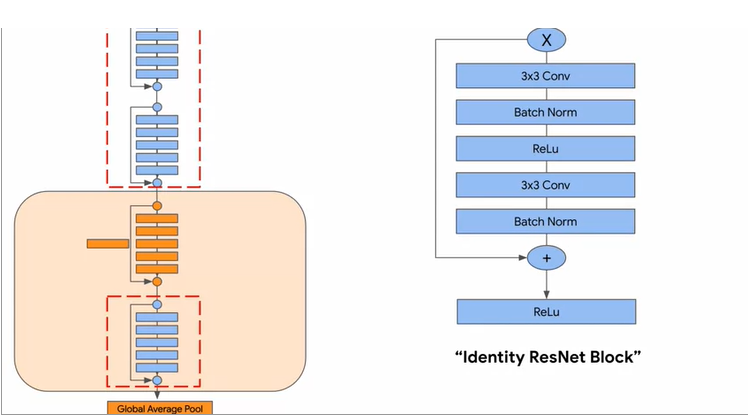

In [ ]:
from IPython.display import Image
Image("resnet_img.png")

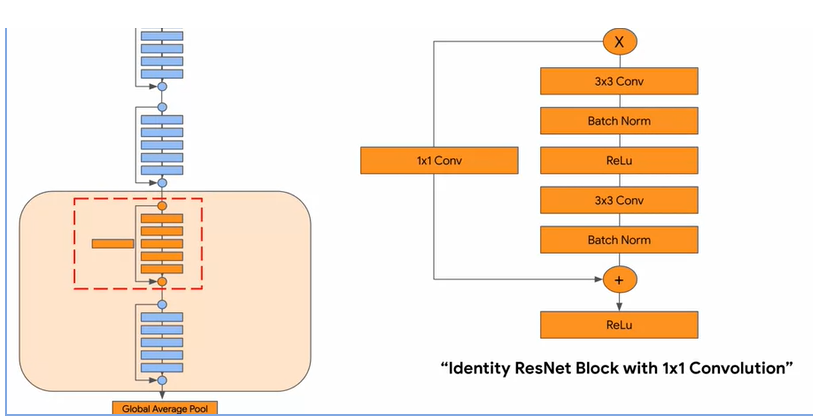

In [ ]:
Image("resnet2_img.png")

In [ ]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
    
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.add([x, input_tensor])
        x = self.act(x)
        return x

In [ ]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        # Use the Identity blocks that you just defined
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)

        x = self.global_pool(x)
        return self.classifier(x)

In [ ]:
# utility function to normalize the images and return (image, label) pairs.
def preprocess(features):
    return tf.cast(features['image'], tf.float32) / 255., features['label']

# create a ResNet instance with 10 output units for MNIST
resnet = ResNet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:

# load and preprocess the dataset
dataset = tfds.load('mnist', split=tfds.Split.TRAIN, data_dir='./data')
dataset = dataset.map(preprocess).batch(32)

In [ ]:
# train the model.
resnet.fit(dataset, epochs=1)

# Implement VGG

In [ ]:
class Block(tf.keras.Model):
    def __init__(self, filters, kernel_size, repetitions, pool_size=2, strides=2):
        super(Block, self).__init__()
        self.filters = filters 
        self.kernel_size = kernel_size 
        self.repetitions = repetitions 
        
        # Define a conv2D_0, conv2D_1, etc based on the number of repetitions
        for i in range(0,3):
            
            # Define a Conv2D layer, specifying filters, kernel_size, activation and padding.
            vars(self)[f'conv2D_{i}'] = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same') # YOUR CODE HERE
        
        # Define the max pool layer that will be added after the Conv2D blocks
        self.max_pool = tf.keras.layers.MaxPooling2D(pool_size, strides) # YOUR CODE HERE
  
    def call(self, inputs):
        # access the class's conv2D_0 layer
        conv2D_0 = vars(self)['conv2D_0']
        
        # Connect the conv2D_0 layer to inputs
        x = conv2D_0(inputs) # YOUR CODE HERE

        # for the remaining conv2D_i layers from 1 to `repetitions` they will be connected to the previous layer
        for i in range(1,3):
            # access conv2D_i by formatting the integer `i`. (hint: check how these were saved using `vars()` earlier)
            conv2D_i = vars(self)[f"conv2D_{i}"] 
            
            # Use the conv2D_i and connect it to the previous layer
            x = conv2D_i(x)

        # Finally, add the max_pool layer
        max_pool = vars(self)['max_pool'](x)
        
        return max_pool

In [ ]:
class MyVGG(tf.keras.Model):

    def __init__(self, num_classes):
        super(MyVGG, self).__init__()

        # Creating blocks of VGG with the following 
        # (filters, kernel_size, repetitions) configurations
        self.block_a = Block(64, 3, 2) 
        self.block_b = Block(128, 3, 2) 
        self.block_c = Block(256, 3, 3) 
        self.block_d = Block(512, 3, 3)
        self.block_e = Block(512, 3, 3)

        # Classification head
        # Define a Flatten layer
        self.flatten = tf.keras.layers.Flatten()
        # Create a Dense layer with 256 units and ReLU as the activation function
        self.fc = tf.keras.layers.Dense(256, activation='relu') # YOUR CODE HERE
        # Finally add the softmax classifier using a Dense layer
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax') # YOUR CODE HERE

    def call(self, inputs):
        # Chain all the layers one after the other
        x = block_a(x) 
        x = block_b(x) 
        x = block_c(x) 
        x = block_d(x)
        x = block_e(x) 
        x = flatten(x) 
        x = fc(x) 
        x = classifier(x)
        return x